In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
data_dir = 'data/dataset/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 25181 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 6295 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [6]:
class_names = train_ds.class_names


In [7]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
IMG_SHAPE = (img_width, img_height, 3)

## VGGNet


In [10]:

basemodel = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
basemodel.trainable = False
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

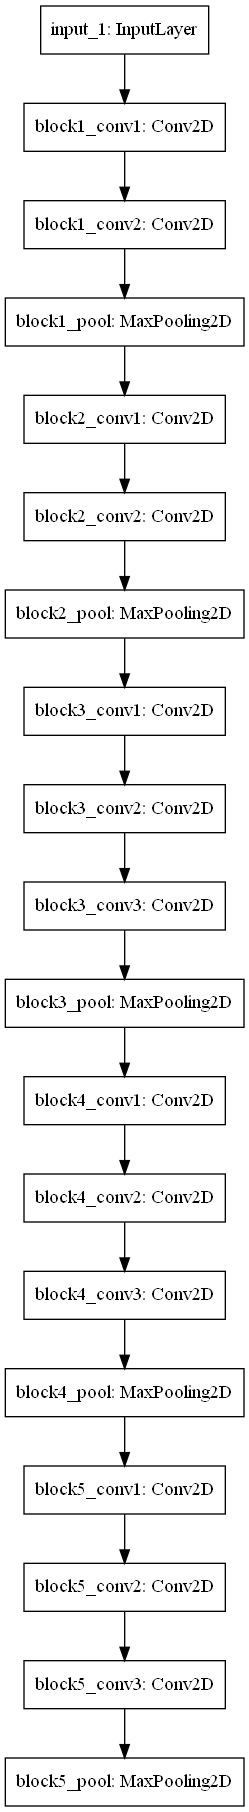

In [11]:
tf.keras.utils.plot_model(
    basemodel,
    to_file="vgg_skeleton.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = basemodel(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [13]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

In [14]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = basemodel(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs,name = 'vggnet_model')
model.summary()

Model: "vggnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 126)              

In [15]:
lr = 0.001
b1 = 0.9
b2 = 0.999 
ep = 1e-07
EPOCHS = 8

In [16]:
checkpoint_filepath = 'models/checkpoints/vggnet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [17]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
      callbacks=[model_checkpoint_callback],
  epochs=EPOCHS
)

Epoch 1/8
787/787 [==============================] - 125s 152ms/step - loss: 2.0330 - accuracy: 0.5466 - val_loss: 0.5159 - val_accuracy: 0.8653
Epoch 2/8
787/787 [==============================] - 156s 198ms/step - loss: 0.4642 - accuracy: 0.8656 - val_loss: 0.2880 - val_accuracy: 0.9241
Epoch 3/8
787/787 [==============================] - 142s 180ms/step - loss: 0.2649 - accuracy: 0.9261 - val_loss: 0.2071 - val_accuracy: 0.9437
Epoch 4/8
787/787 [==============================] - 160s 203ms/step - loss: 0.1910 - accuracy: 0.9471 - val_loss: 0.1619 - val_accuracy: 0.9556
Epoch 5/8
787/787 [==============================] - 143s 181ms/step - loss: 0.1459 - accuracy: 0.9589 - val_loss: 0.1438 - val_accuracy: 0.9604
Epoch 6/8
787/787 [==============================] - 157s 199ms/step - loss: 0.1212 - accuracy: 0.9657 - val_loss: 0.1270 - val_accuracy: 0.9647
Epoch 7/8
787/787 [==============================] - 141s 179ms/step - loss: 0.1016 - accuracy: 0.9718 - val_loss: 0.1103 - val_ac

In [18]:
loss_p, accuracy = model.evaluate(val_ds)
accuracy = accuracy * 100
print(f"Loss: {loss_p:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

158/158 [==============================] - 18s 115ms/step - loss: 0.1098 - accuracy: 0.9697
Loss: 0.11%
Accuracy: 96.97%


In [19]:
import datetime
today = datetime.datetime.now()
folder_name = f'{today.hour}-{today.minute}_{today.day:02d}-{today.month}-{today.year}'
path = os.path.join('results','model_summary','vggnet',folder_name)
if not os.path.exists(path):
    os.makedirs(path)
model_folder = path

In [20]:
import pickle
pickle.dump(history.history, open(model_folder+'\history.pickle', 'wb'))

In [21]:
# save as directory
model.save(model_folder+'\model')

INFO:tensorflow:Assets written to: results\model_summary\vggnet\22-54_23-3-2022\model\assets


In [22]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}-acc{int(accuracy)}.h5')

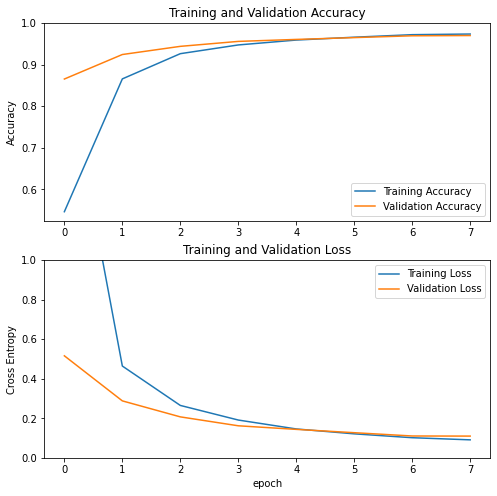

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\combined.png')
plt.show()

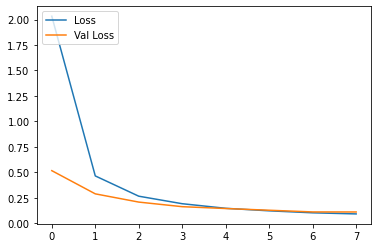

In [24]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\loss.png')
plt.show()

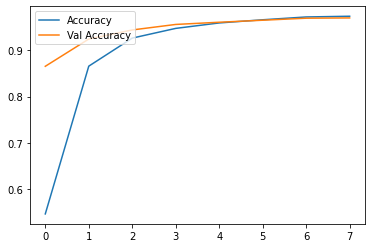

In [25]:
plt.plot(history.history['accuracy'],label="Accuracy")
plt.plot(history.history['val_accuracy'],label="Val Accuracy")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\\accuracy.png')
plt.show()

### Fine tuning

In [26]:
# backup 
og_model = model

In [27]:
print("Number of layers in the base model: ", len(basemodel.layers))

Number of layers in the base model:  19


In [28]:
basemodel.trainable = True 

In [29]:
# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
lr = 1e-05
b1 = 0.9
b2 = 0.999 
ep = 1e-07

In [31]:
checkpoint_filepath = 'models/checkpoints/vggnet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [32]:
model.summary()

Model: "vggnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 126)              

In [33]:
fine_tune_epochs = 4
total_epochs =  EPOCHS + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                        callbacks=[model_checkpoint_callback],
                         validation_data=val_ds)

Epoch 8/12
787/787 [==============================] - 218s 274ms/step - loss: 0.0575 - accuracy: 0.9816 - val_loss: 0.0501 - val_accuracy: 0.9836
Epoch 9/12
787/787 [==============================] - 194s 246ms/step - loss: 0.0275 - accuracy: 0.9906 - val_loss: 0.0541 - val_accuracy: 0.9840
Epoch 10/12
787/787 [==============================] - 208s 264ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.0441 - val_accuracy: 0.9857
Epoch 11/12
787/787 [==============================] - 199s 253ms/step - loss: 0.0151 - accuracy: 0.9952 - val_loss: 0.0321 - val_accuracy: 0.9903
Epoch 12/12
787/787 [==============================] - 208s 264ms/step - loss: 0.0172 - accuracy: 0.9939 - val_loss: 0.0398 - val_accuracy: 0.9887


In [34]:
model.load_weights(checkpoint_filepath)

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

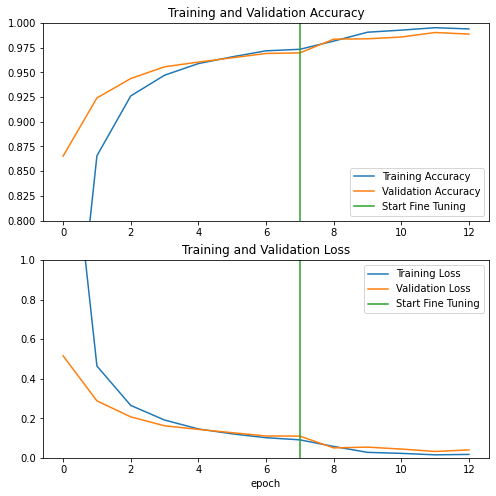

In [36]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\combined_finetuned.png')
plt.show()

In [37]:
loss_finetuned, accuracy_finetuned = model.evaluate(test_dataset)
accuracy_finetuned = accuracy_finetuned * 100
print('Test accuracy :', accuracy_finetuned)

39/39 [==============================] - 5s 126ms/step - loss: 0.0330 - accuracy: 0.9936
Test accuracy : 99.35897588729858


In [38]:
def predict_word(num):
    pred = ''
    ch = class_names[num]
    lis = ch.split(' ')
    char_list = [chr(int(i)) for i in lis]
    pred += ''.join(char_list)
    return pred

In [39]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [40]:
predictions = predictions.argmax(axis=-1)

In [41]:
from matplotlib.font_manager import FontProperties
from pathlib import Path
# point to the font location with an absolute path
nirm = Path('c:/Windows/Fonts/kartika.ttf')

# configure the Hindi font
mal_font = FontProperties(fname=nirm)

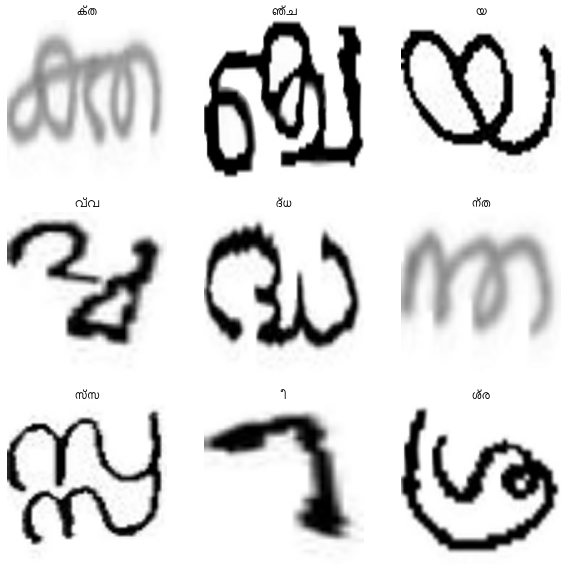

In [42]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  pred_word = predict_word(predictions[i])
  plt.title(pred_word,fontproperties=mal_font)
  plt.savefig(model_folder+'\prediction.jpg')
  plt.axis("off")

In [43]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}_vggnet_finetuned_{today.hour}-{today.minute}_{today.day:02d}-{today.month}-{today.year}-acc{int(accuracy)}.h5')

In [44]:
# save as directory
model.save(model_folder+f'\model_finetuned')

INFO:tensorflow:Assets written to: results\model_summary\vggnet\22-54_23-3-2022\model_finetuned\assets


In [45]:
classes = np.array(class_names)

In [46]:
with open(model_folder+'\class_names.npy', 'wb') as f:
    np.save(f, classes)

In [47]:
pickle.dump(history_fine.history, open(model_folder+'\history_fine.pickle', 'wb'))

In [48]:
f = open(model_folder+"\\config.txt", "w")
f.writelines([f'LR: {lr}\n',f'Beta 1:{b1}\n',f'Beta 2:{b2}\n',f'Classes: {num_classes}',f'epsilon:{ep}\n',f'epochs:{EPOCHS}\n',f'accuracy: {accuracy}\n',f'accuracy finetuned: {accuracy_finetuned}\n'])
f.close()

In [3]:
float(1e-05)

1e-05